In [1]:
%matplotlib inline
%qtconsole --colors=linux

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano as thno
import theano.tensor as T

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

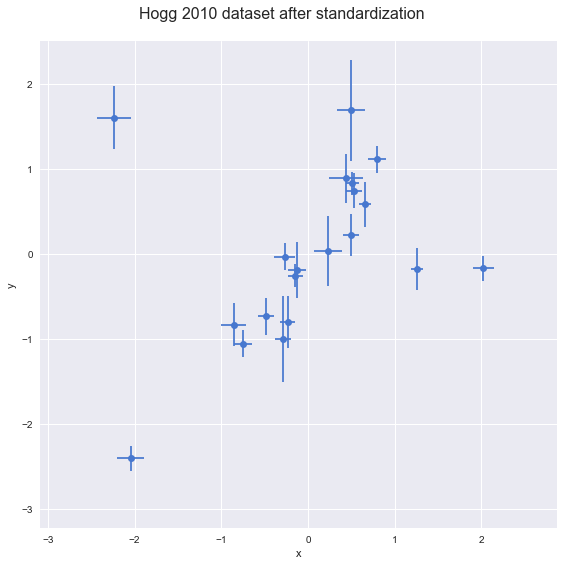

In [2]:
#### cut & pasted directly from the fetch_hogg2010test() function
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

## create xlims ylims for plotting
xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5
                 ,dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5
                 ,dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

## scatterplot the standardized data
g = sns.FacetGrid(dfhoggs, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Hogg 2010 dataset after standardization', fontsize=16)

In [3]:
with pm.Model() as mdl_ols:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)

    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']

    ## Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=thno.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=dfhoggs['y'])

In [4]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 145.777745
         Iterations: 3
         Function evaluations: 118


100%|██████████| 2000/2000 [00:02<00:00, 871.26it/s] 


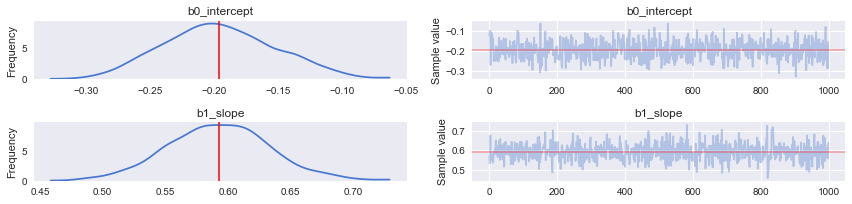

In [5]:
_ = pm.traceplot(traces_ols[-1000:], figsize=(12,len(traces_ols.varnames)*1.5),
                lines={k: v['mean'] for k, v in pm.df_summary(traces_ols[-1000:]).iterrows()})

Instead of using a Normal distribution for the likelihood, we use a Student-T, which has fatter tails. In theory this allows outliers to have a smaller mean square error in the likelihood, and thus have less influence on the regression estimation. This method does not produce inlier / outlier flags but is simpler and faster to run than the Signal Vs Noise model below, so a comparison seems worthwhile.

In [6]:
with pm.Model() as mdl_studentt:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)

    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']

    ## Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=thno.config.floatX), name='sigma_y')

    ## define prior for Student T degrees of freedom
    nu = pm.DiscreteUniform('nu', lower=1, upper=100)

    ## Define Student T likelihood
    likelihood = pm.StudentT('likelihood', mu=yest, sd=sigma_y, nu=nu
                           ,observed=dfhoggs['y'])


In [7]:
with mdl_studentt:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## two-step sampling to allow Metropolis for nu (which is discrete)
    step1 = pm.NUTS([b0, b1])
    step2 = pm.Metropolis([nu])

    ## take samples
    traces_studentt = pm.sample(2000, start=start_MAP, step=[step1, step2], progressbar=True)

Optimization terminated successfully.
         Current function value: 107.488021
         Iterations: 3
         Function evaluations: 77


100%|██████████| 2000/2000 [00:03<00:00, 604.30it/s]


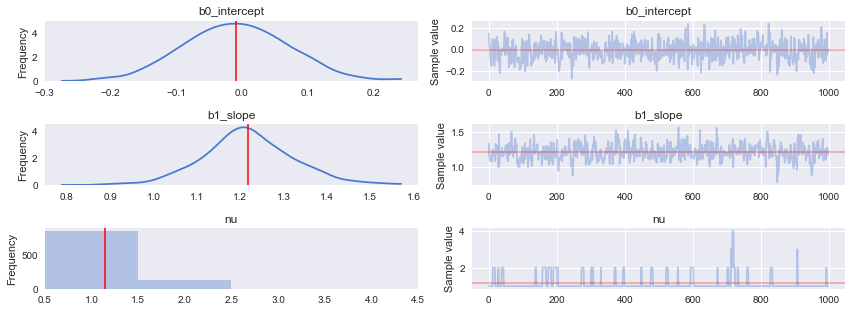

In [8]:
_ = pm.traceplot(traces_studentt[-1000:]
            ,figsize=(12,len(traces_studentt.varnames)*1.5)
            ,lines={k: v['mean'] for k, v in pm.df_summary(traces_studentt[-1000:]).iterrows()})

$\bullet$ Both parameters b0 and b1 show quite a skew to the right, possibly this is the action of a few samples regressing closer to the OLS estimate which is towards the left

$\bullet$ The nu parameter seems very happy to stick at nu = 1, indicating that a fat-tailed Student-T likelihood has a better fit than a thin-tailed (Normal-like) Student-T likelihood.

$\bullet$ The inference sampling also ran very quickly, almost as quickly as the conventional OLS


Create Robust Model with Outliers: Hogg Method

Please read the paper (Hogg 2010) and Jake Vanderplas’ code for more complete information about the modelling technique.

The general idea is to create a ‘mixture’ model whereby datapoints can be described by either the linear model (inliers) or a modified linear model with different mean and larger variance (outliers).

The likelihood is evaluated over a mixture of two likelihoods, one for ‘inliers’, one for ‘outliers’. A Bernouilli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:
$\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]$

In [9]:
def logp_signoise(yobs, is_outlier, yest_in, sigma_y_in, yest_out, sigma_y_out):
    '''
    Define custom loglikelihood for inliers vs outliers.
    NOTE: in this particular case we don't need to use theano's @as_op
    decorator because (as stated by Twiecki in conversation) that's only
    required if the likelihood cannot be expressed as a theano expression.
    We also now get the gradient computation for free.
    '''

    # likelihood for inliers
    pdfs_in = T.exp(-(yobs - yest_in + 1e-4)**2 / (2 * sigma_y_in**2))
    pdfs_in /= T.sqrt(2 * np.pi * sigma_y_in**2)
    logL_in = T.sum(T.log(pdfs_in) * (1 - is_outlier))

    # likelihood for outliers
    pdfs_out = T.exp(-(yobs - yest_out + 1e-4)**2 / (2 * (sigma_y_in**2 + sigma_y_out**2)))
    pdfs_out /= T.sqrt(2 * np.pi * (sigma_y_in**2 + sigma_y_out**2))
    logL_out = T.sum(T.log(pdfs_out) * is_outlier)

    return logL_in + logL_out

In [10]:
with pm.Model() as mdl_signoise:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)

    ## Define linear model
    yest_in = b0 + b1 * dfhoggs['x']

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=100)
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=100)

    ## Define Bernoulli inlier / outlier flags according to a hyperprior
    ## fraction of outliers, itself constrained to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0])

    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = thno.shared(np.asarray(dfhoggs['y'], dtype=thno.config.floatX), name='yobs')
    sigma_y_in = thno.shared(np.asarray(dfhoggs['sigma_y']
                                , dtype=thno.config.floatX), name='sigma_y_in')

    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist('likelihood', logp_signoise,
                        observed={'yobs':yobs, 'is_outlier':is_outlier,
                                  'yest_in':yest_in, 'sigma_y_in':sigma_y_in,
                                  'yest_out':yest_out, 'sigma_y_out':sigma_y_out})

In [16]:
with mdl_signoise:

    ## two-step sampling to create Bernoulli inlier/outlier flags
    step1 = pm.NUTS([frac_outliers, yest_out, sigma_y_out, b0, b1])
    step2 = pm.BinaryMetropolis([is_outlier], tune_interval=100)

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_signoise = pm.sample(2000, start=start_MAP, step=[step1,step2], progressbar=True)

  0%|          | 10/2000 [00:00<00:27, 73.30it/s]

Optimization terminated successfully.
         Current function value: 155.449990
         Iterations: 3
         Function evaluations: 213


100%|██████████| 2000/2000 [14:27<00:00,  2.31it/s]


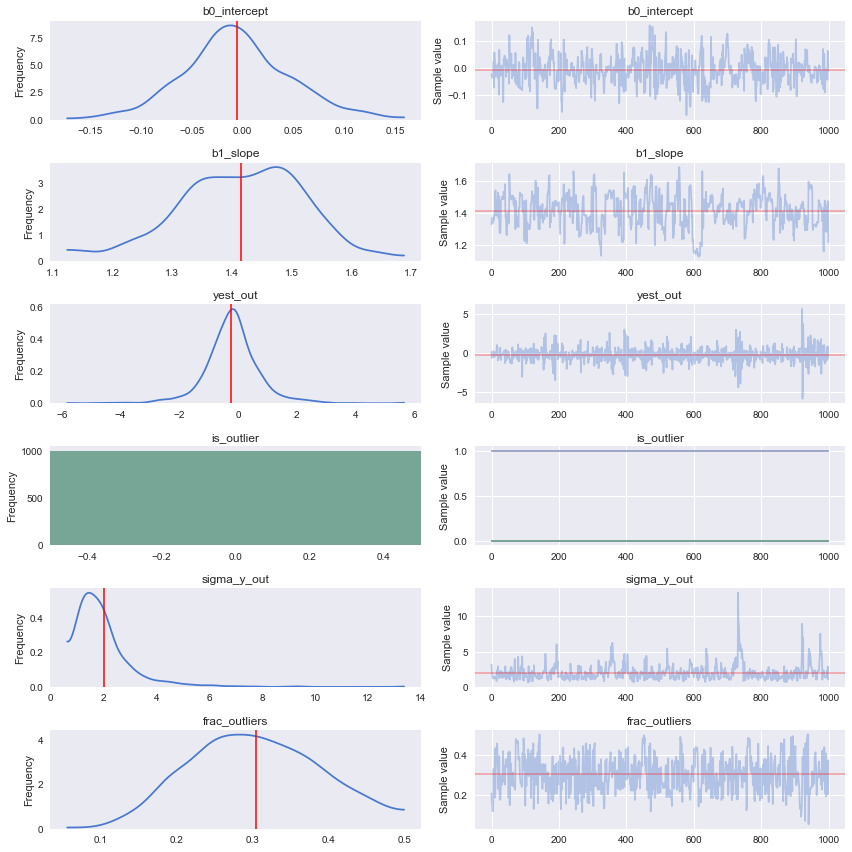

In [17]:
_ = pm.traceplot(traces_signoise[-1000:], figsize=(12,len(traces_signoise.varnames)*1.5),
            lines={k: v['mean'] for k, v in pm.df_summary(traces_signoise[-1000:]).iterrows()})

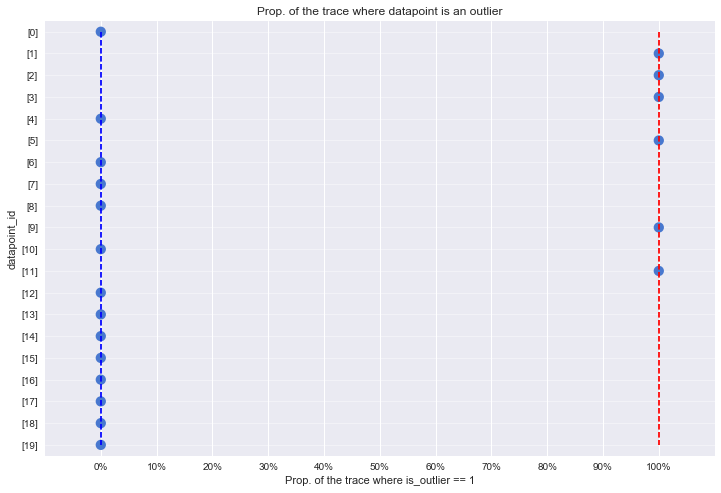

In [18]:
outlier_melt = pd.melt(pd.DataFrame(traces_signoise['is_outlier', -1000:],
                                   columns=['[{}]'.format(int(d)) for d in dfhoggs.index]),
                      var_name='datapoint_id', value_name='is_outlier')
ax0 = sns.pointplot(y='datapoint_id', x='is_outlier', data=outlier_melt,
                   kind='point', join=False, ci=None, size=4, aspect=2)

_ = ax0.vlines([0,1], 0, 19, ['b','r'], '--')

_ = ax0.set_xlim((-0.1,1.1))
_ = ax0.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax0.set_xticklabels(['{:.0%}'.format(t) for t in np.arange(0,1.1,0.1)])

_ = ax0.yaxis.grid(True, linestyle='-', which='major', color='w', alpha=0.4)
_ = ax0.set_title('Prop. of the trace where datapoint is an outlier')
_ = ax0.set_xlabel('Prop. of the trace where is_outlier == 1')

In [19]:
cutoff = 5
dfhoggs['outlier'] = np.percentile(traces_signoise[-1000:]['is_outlier'],cutoff, axis=0)
dfhoggs['outlier'].value_counts()

0.0    14
1.0     6
Name: outlier, dtype: int64

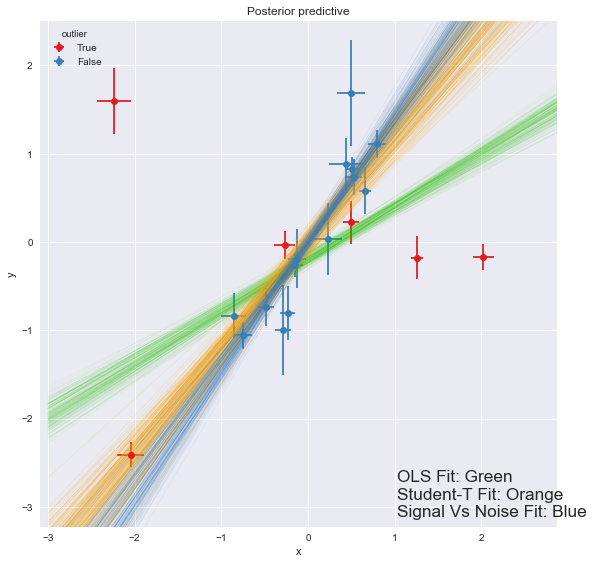

In [20]:
g = sns.FacetGrid(dfhoggs, size=8, hue='outlier', hue_order=[True,False],
                  palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0_intercept'] + samp['b1_slope'] * x

pm.glm.plot_posterior_predictive(traces_ols[-1000:],
        eval=np.linspace(-3, 3, 10), lm=lm, samples=200, color='#22CC00', alpha=.2)

pm.glm.plot_posterior_predictive(traces_studentt[-1000:], lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#FFA500', alpha=.5)

pm.glm.plot_posterior_predictive(traces_signoise[-1000:], lm=lm,
        eval=np.linspace(-3, 3, 10), samples=200, color='#357EC7', alpha=.3)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='').add_legend()

_ = g.axes[0][0].annotate('OLS Fit: Green\nStudent-T Fit: Orange\nSignal Vs Noise Fit: Blue',
                          size='x-large', xy=(1,0), xycoords='axes fraction',
                          xytext=(-160,10), textcoords='offset points')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

References:

Hogg, D. W., J. Bovy, and D. Lang (2010). Data analysis recipes: Fitting a model to
data. ArXiv:astro-ph/1008.4686.